In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
titanic_data = pd.read_csv('train.csv')

In [30]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


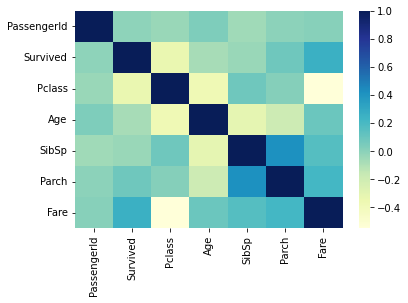

In [31]:
import seaborn as sns

sns.heatmap(titanic_data.corr(), cmap='YlGnBu')
plt.show()

In [32]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(titanic_data, titanic_data[['Survived', 'Pclass', 'Sex']]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

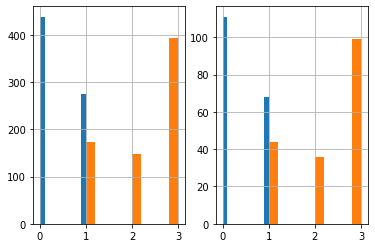

In [33]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

plt.show()

In [34]:
strat_train_set.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            147
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          556
Embarked         2
dtype: int64

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy='mean')
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

In [36]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        column_names = ['C', 'S', 'Q', 'N']
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        matrix = encoder.fit_transform(X[['Sex']]).toarray()
        column_names = ['Female', 'Male']
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        return X

In [37]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(['Embarked', 'Name', 'Ticket', 'Cabin', 'Sex', 'N'], axis=1, errors='ignore')

In [38]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('ageimputer', AgeImputer()),
                     ('fetureencoder', FeatureEncoder()), 
                     ('featuredropper', FeatureDropper())])

In [39]:
strat_train_set = pipeline.fit_transform(strat_train_set)

[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]
712
[[0. 1. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
4


In [13]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survived'], axis=1)
y = strat_train_set['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

param_grid = [
    {'n_estimators': [10,100, 200, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2,3,4]}
]
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [15]:
final_clf = grid_search.best_estimator_

In [16]:
final_clf

RandomForestClassifier(max_depth=5, min_samples_split=3, n_estimators=200)

In [17]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [18]:
X_test = strat_test_set.drop(['Survived'], axis=1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [19]:
final_clf.score(X_test, y_test)

0.8435754189944135

In [20]:
final_data = pipeline.fit_transform(titanic_data)
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [21]:
X_final = final_data.drop(['Survived'], axis=1)
y_final = final_data['Survived']

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [22]:
prod_clf = RandomForestClassifier()

param_grid = [
    {'n_estimators': [10, 100, 200, 500, 1000],
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_split': [2,3,4]}
]
grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(X_final, y_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10, 15, 20, 25],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500, 1000]}],
             return_train_score=True, scoring='accuracy')

In [35]:
prod_final_clf = grid_search.best_estimator_

In [36]:
prod_final_clf.score(X_final, y_final)

0.856341189674523

In [34]:
from sklearn.metrics import roc_auc_score

In [25]:
titanic_test_data = pd.read_csv('test.csv')

In [26]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [27]:
X_final_test = final_test_data.fillna(method='ffill')

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

In [31]:
predictions = prod_final_clf.predict(X_final_test)

In [32]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv('predict.csv', index=False)